In [78]:
#importing libraries as well as my dataset.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("data.csv")
shooting_stats = pd.read_csv('Player Shooting Stats.csv')
#shooting_stats.head()

In [79]:
#want to make a new dataset that finds the shots that are shot, matches them with the player shooting, and finds the expected split

#first, I am going to make some edits to the dataset that get rid of players on multiple teams
#those players have a combined row with takes all their data and combines it into one, and I am taking the combined row out
drop_con = (shooting_stats['Tm'] == 'TOT')
shooting_stats = shooting_stats[~drop_con]


data['Shooting Percent at Distance'] = pd.NA
data['Expected Points per Shot'] = pd.NA

#getting column indexes
distance_percent_value = data.columns.get_loc('Shooting Percent at Distance')
player_name_value = data.columns.get_loc('player_name')
distance_column_value = data.columns.get_loc('result_dist')
tm_column = data.columns.get_loc('off_team')
pts_value = data.columns.get_loc('result_pts')

#getting indexes for the shooting splits dataframe
short, short_mid, mid_mid, long_mid, three_point, corner_three = np.arange(9,15)

#creating a function to sort the shot distance into our given shot distance categories
def shot_convert(distance, points):
    if 0 <= distance < 3:
        val = 4
    elif 3 <= distance < 10:
        val = 5
    elif 10 <= distance < 16:
        val = 6
    elif (22 <= distance < 23.75) and (points == 3):
        val = 9
    elif 16 <= distance < 23.75:
        val = 7
    else:
        val = 8
    return val

#now making a function that uses the player's name, team, and shot distance to find their FG% from that area
def percentage_finder(val1, val2, val3, val4):
    selected_row = shooting_stats.loc[(shooting_stats['Player'] == val1) & (shooting_stats['Tm'] == val2)]
    # Check if selected_row is empty
    if not selected_row.empty:
        range_column = shot_convert(val3, val4) 
        # Check if range_column is within the valid range
        if 0 <= range_column < len(selected_row.columns):
            percentage = selected_row.iloc[0, range_column]
            return percentage
        else:
            print(f"Invalid range_column: {range_column}")
            return None
    else:
        print(f"No matching rows for {val1} and {val2}")
        return None  # or return a default value or handle accordingly

#for the made shots
for i in range(len(data)):
    if (data.iloc[i, pts_value] in [1, 2, 3]) and (data.iloc[i, 14] == 'OFF'):
        name = data.iloc[i, player_name_value]
        team = data.iloc[i, tm_column]
        distance = data.iloc[i, distance_column_value]
        points = data.iloc[i, pts_value]
        data.iloc[i,-2] = percentage_finder(name, team, distance, points)
        data.iloc[i,-1] = (data.iloc[i,-2] * data.iloc[i, pts_value])
    else:
        continue
#now we have a dataframe with a shooting percentage for each specific player at distance and the expected value of their shot

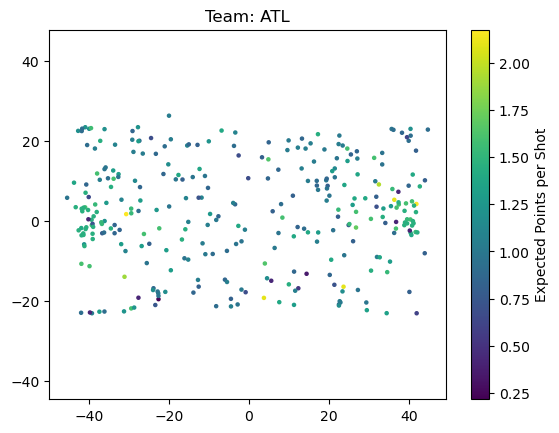

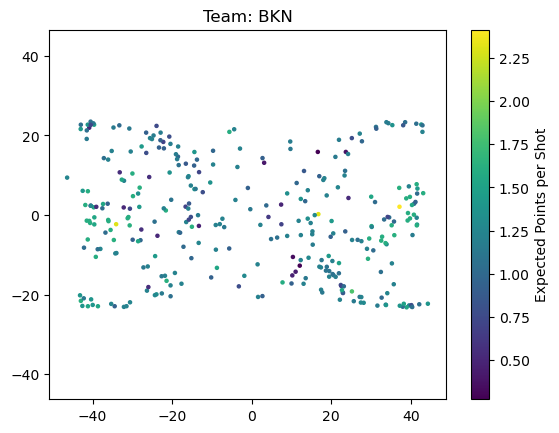

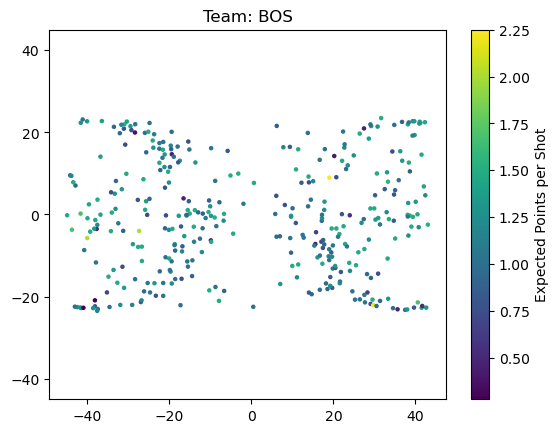

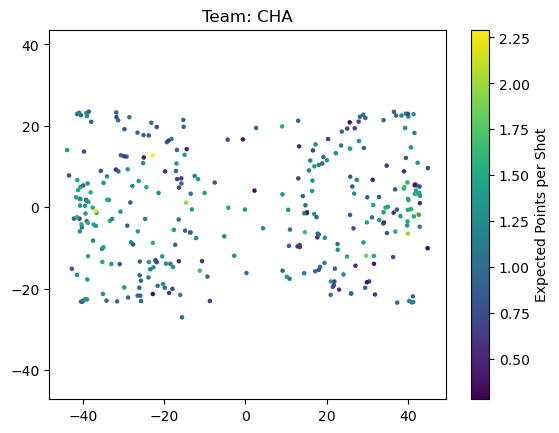

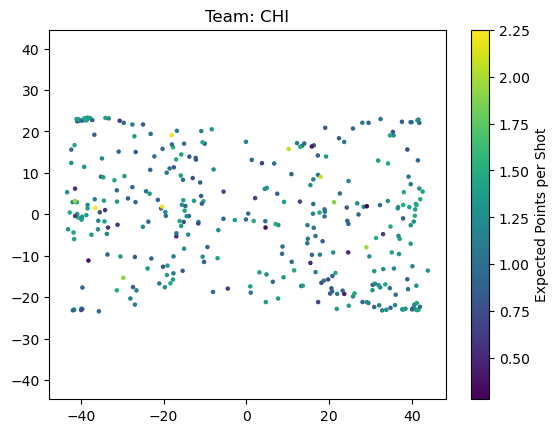

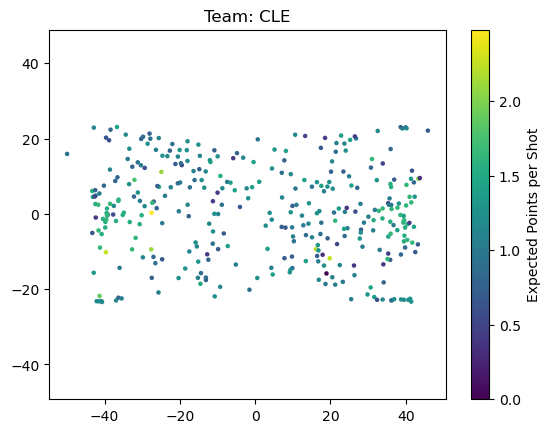

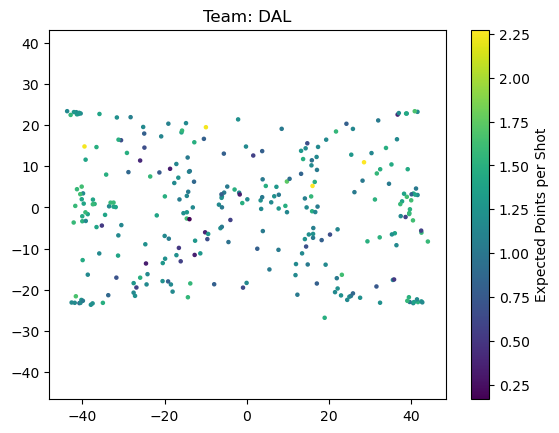

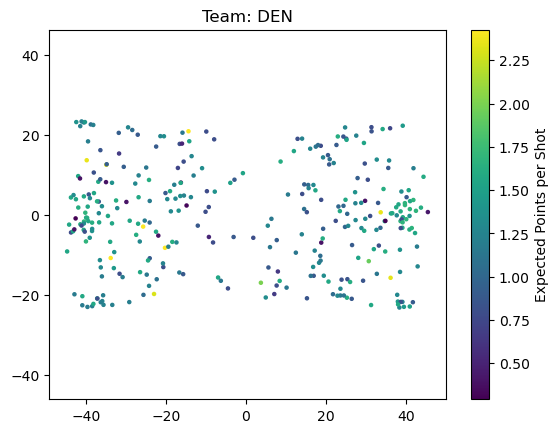

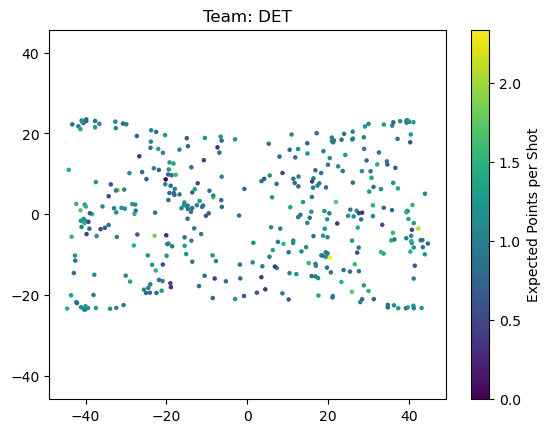

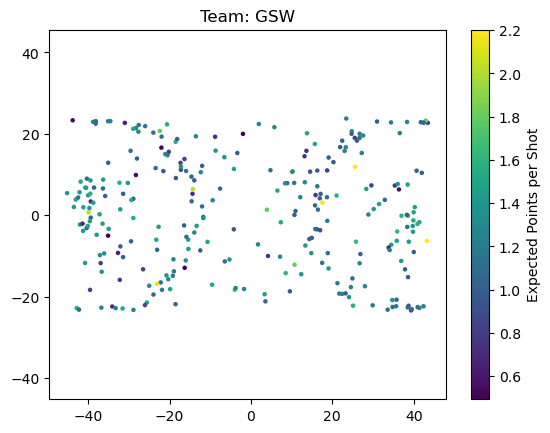

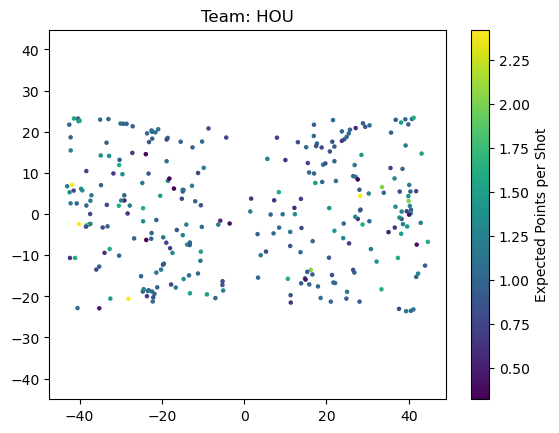

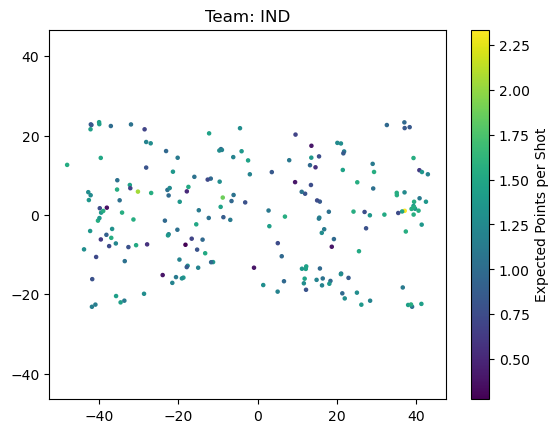

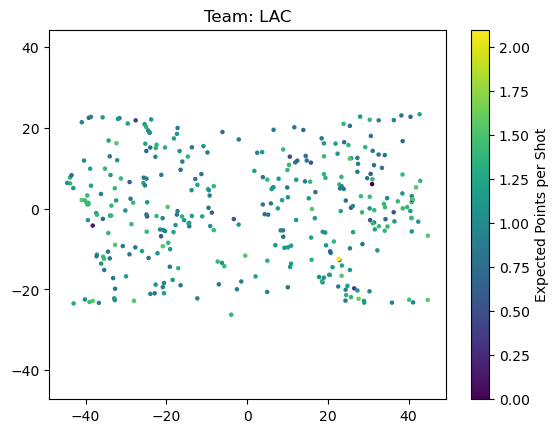

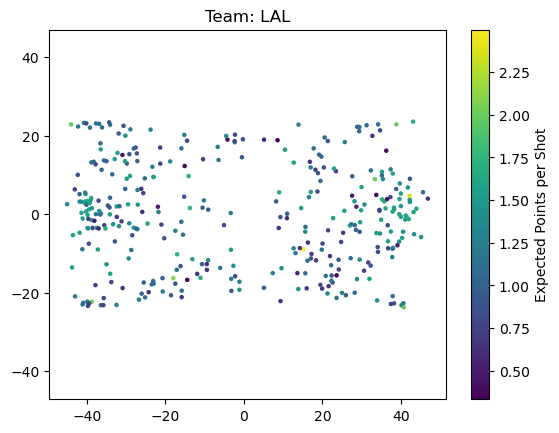

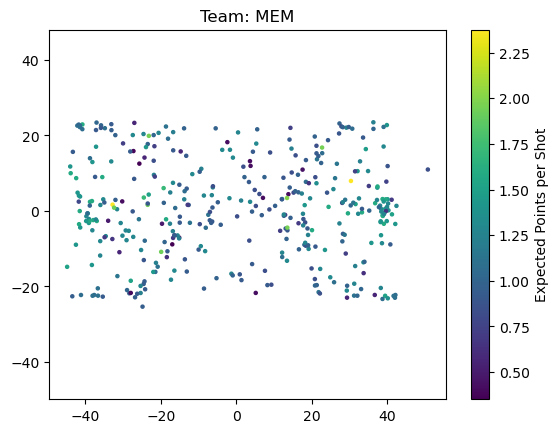

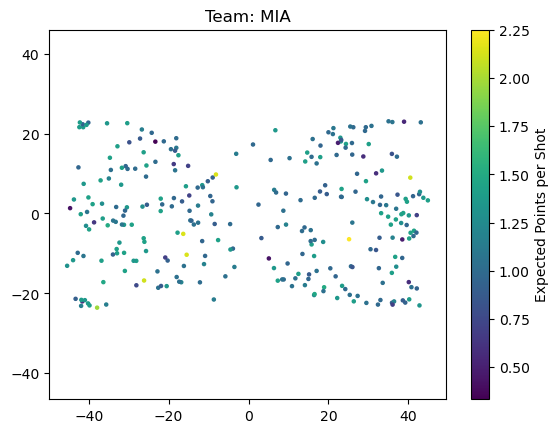

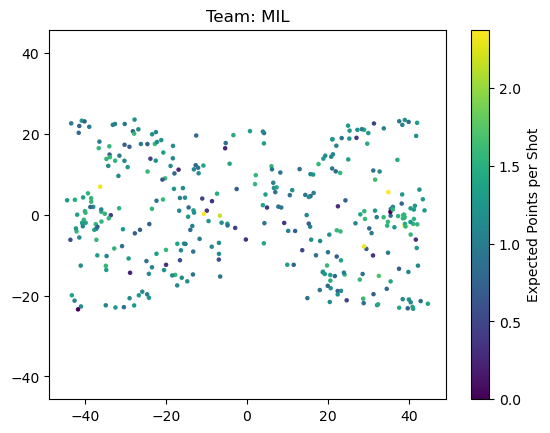

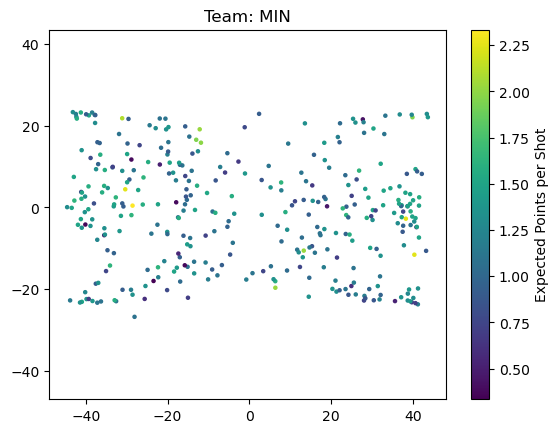

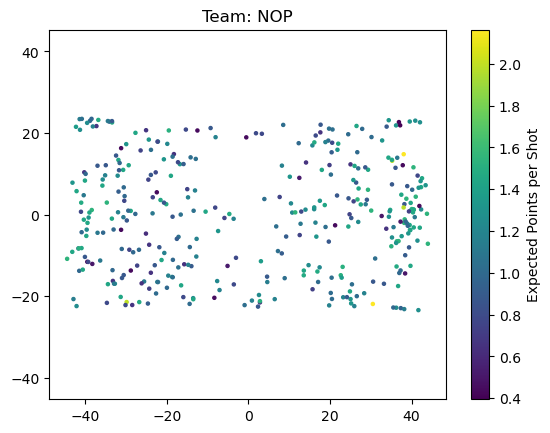

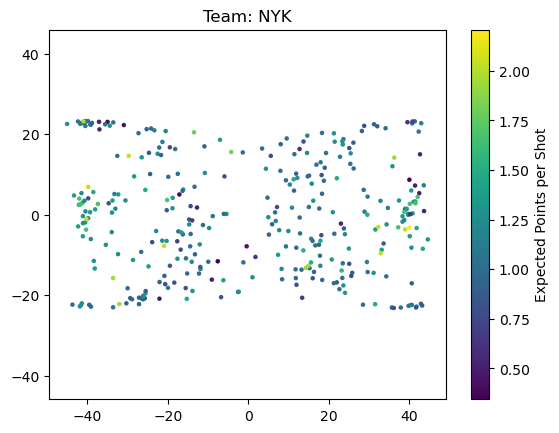

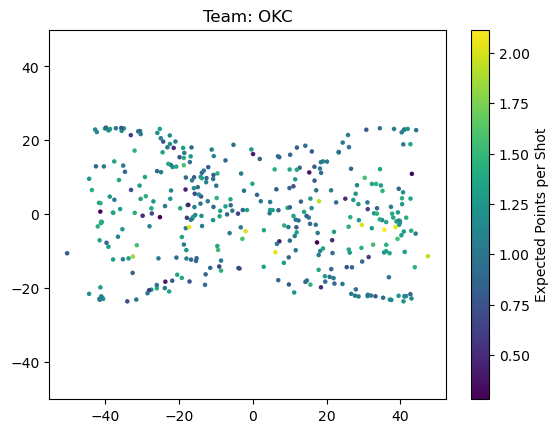

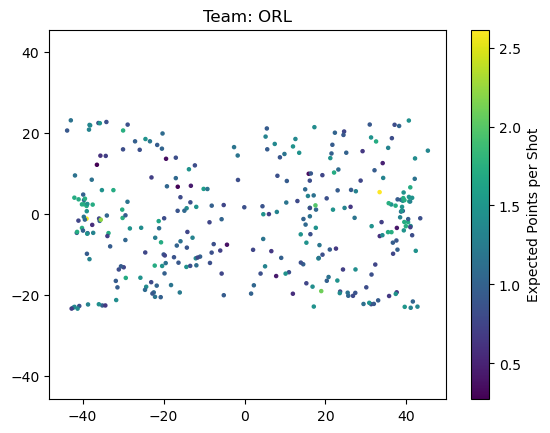

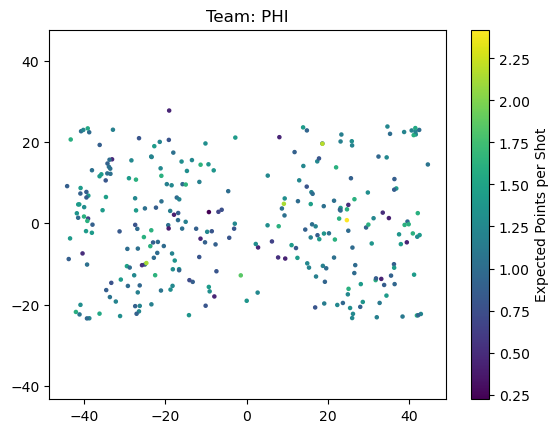

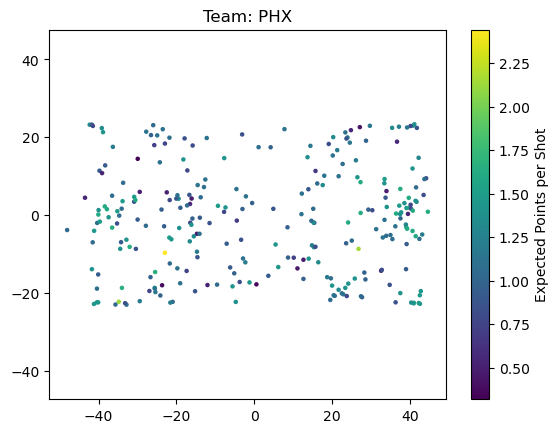

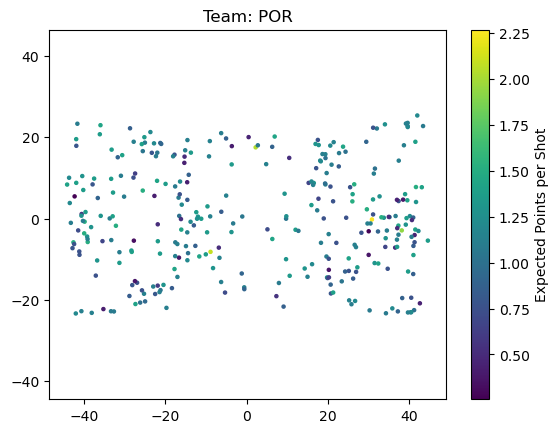

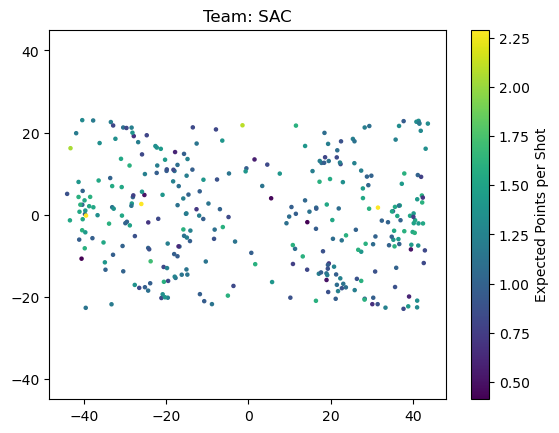

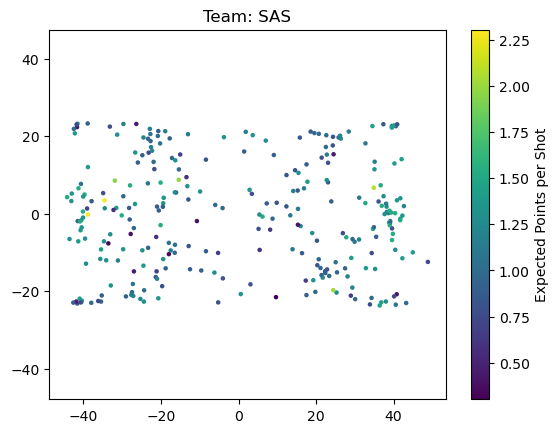

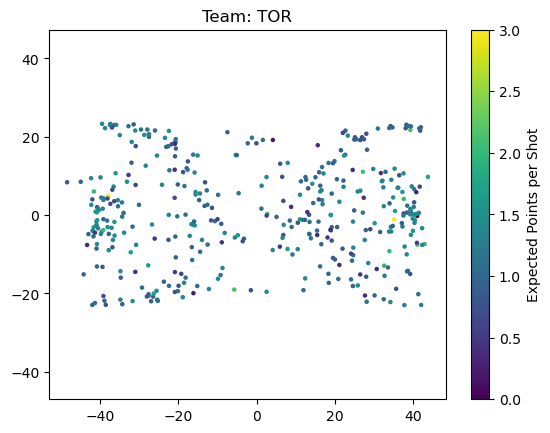

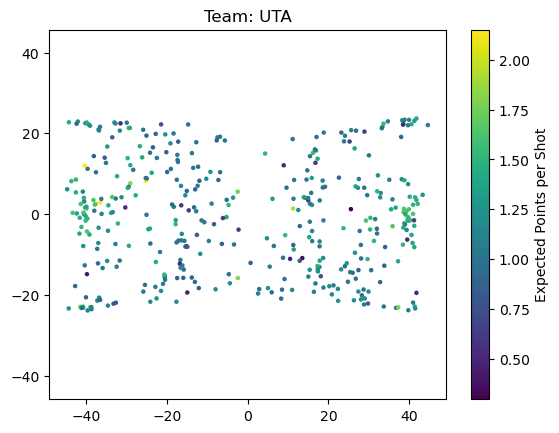

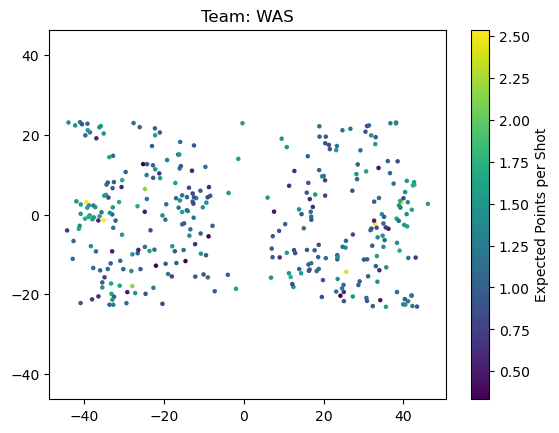

Empty DataFrame
Columns: []
Index: []

In [80]:
#making graphs for each team with locations of successful shots

# starting with making a dataframe with only made shots
column_check = ['Shooting Percent at Distance', 'Expected Points per Shot']
made_shots = data.dropna(subset = column_check)

#grouping by offensive team
team_shots = made_shots.groupby("off_team")

#importing matplotlib.pyplot and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#making graphs on where these offensive shots come from
def graphs(group):
    plt.axis('equal')
    plt.scatter(group['player_x'], group['player_y'], c = group['Expected Points per Shot'], cmap = 'viridis', marker = 'o', s = 5)
    plt.colorbar(label = 'Expected Points per Shot')
    plt.title(f'Team: {group.name}')
    plt.show()

#apply the custom function to each group
team_shots.apply(graphs)

C:\Users\ghosh\AppData\Local\Temp\ipykernel_22184\1090747249.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')


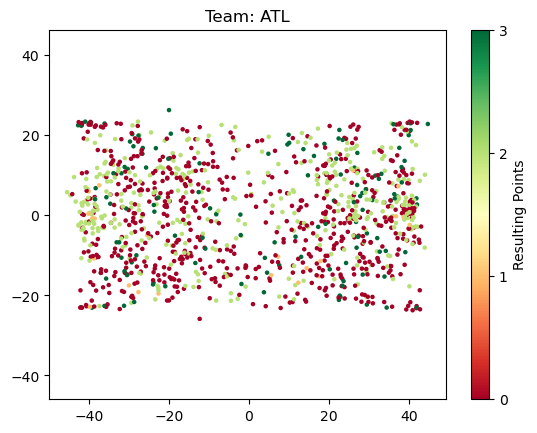

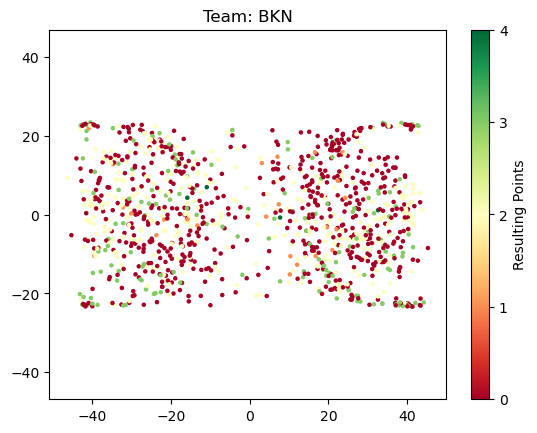

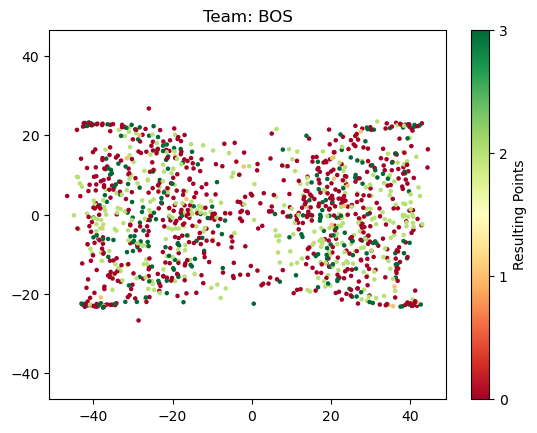

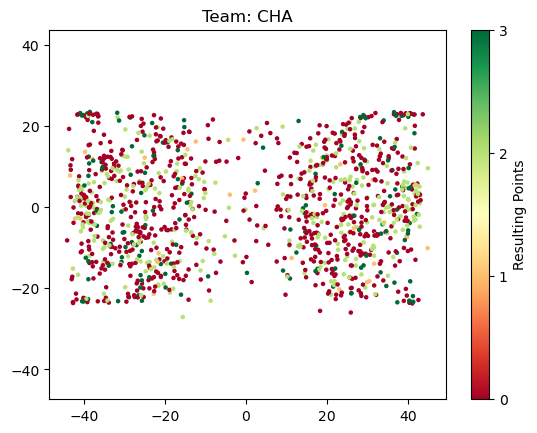

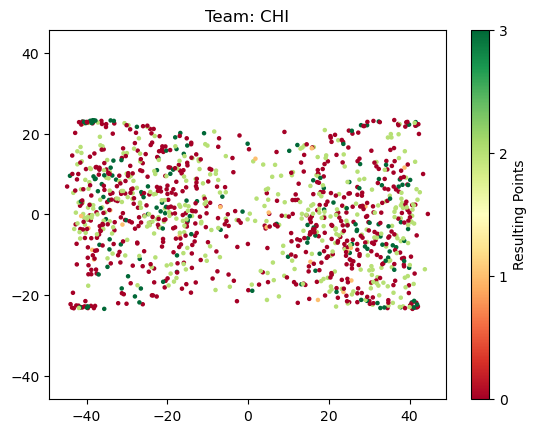

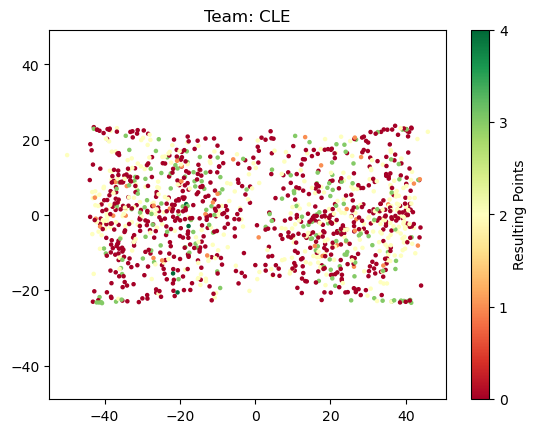

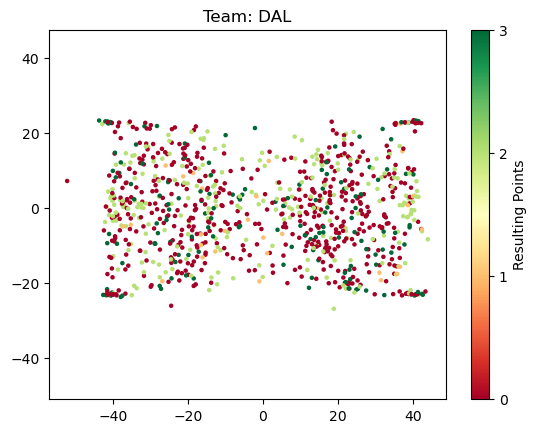

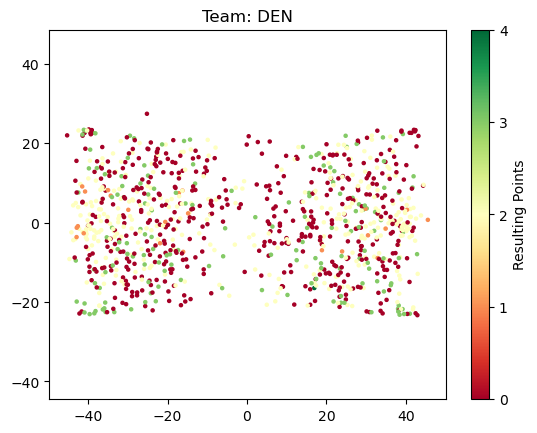

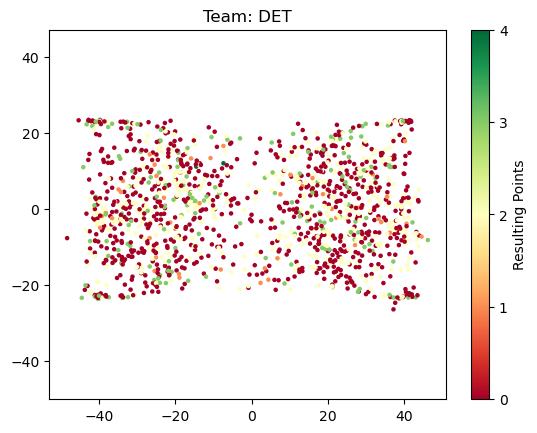

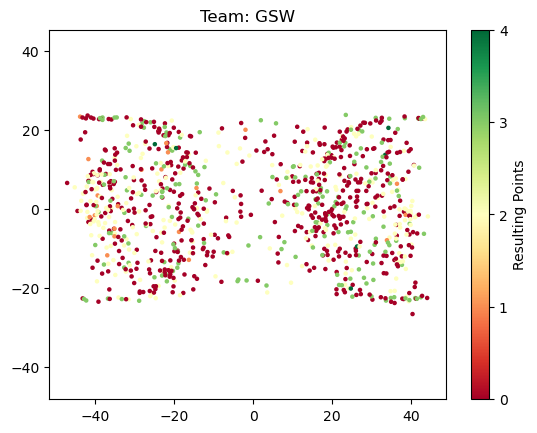

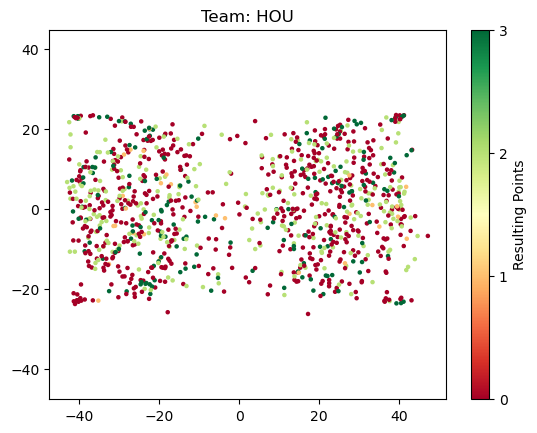

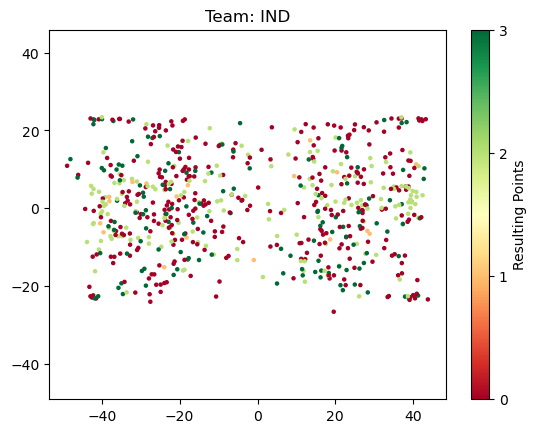

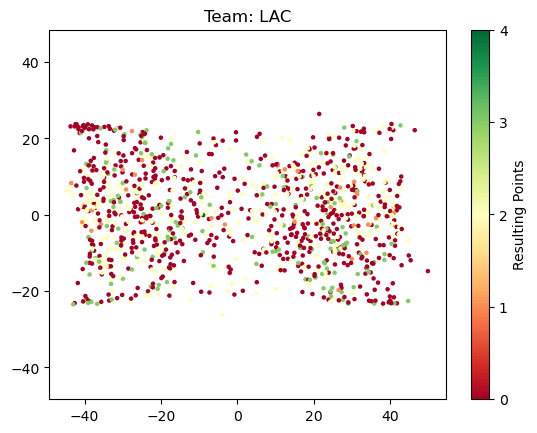

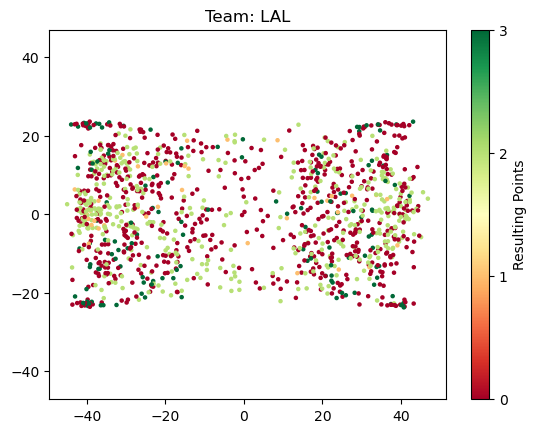

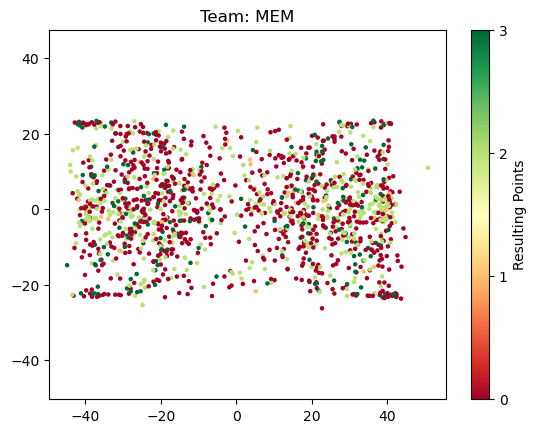

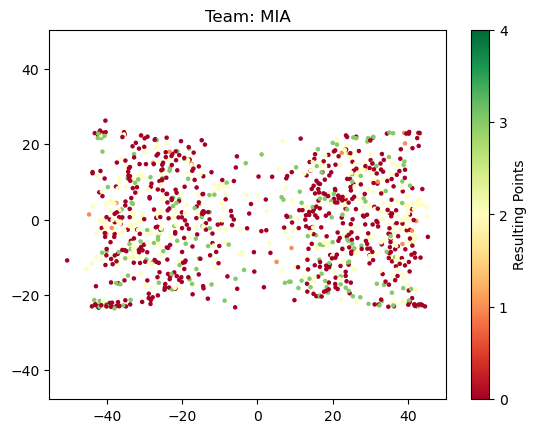

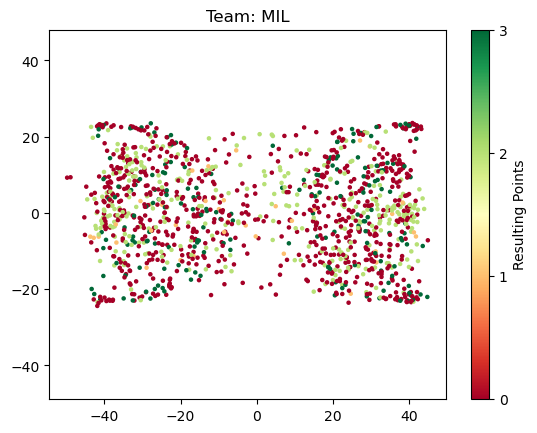

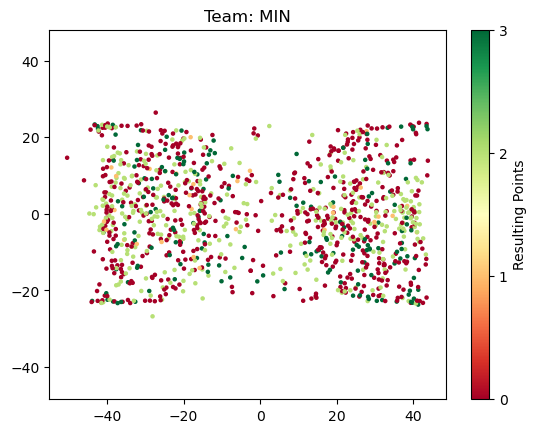

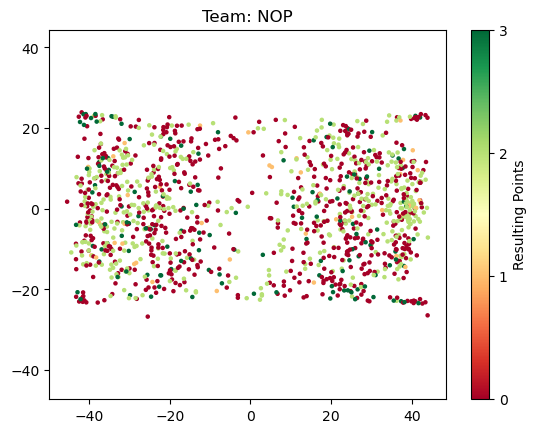

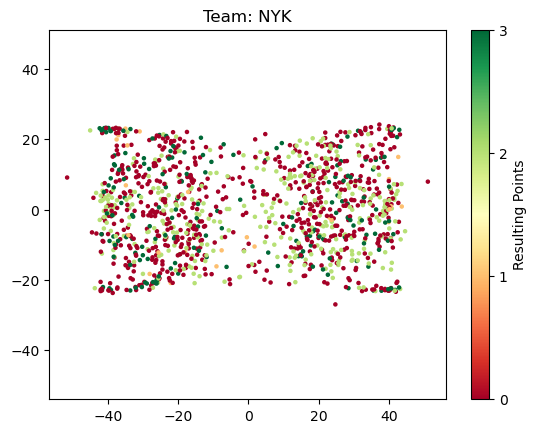

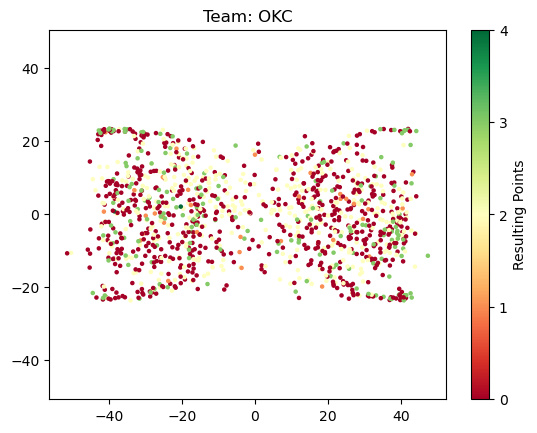

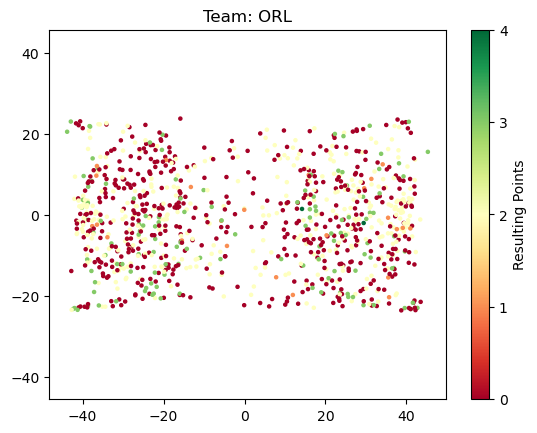

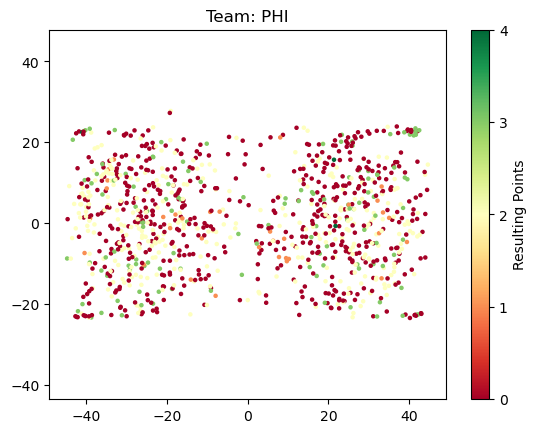

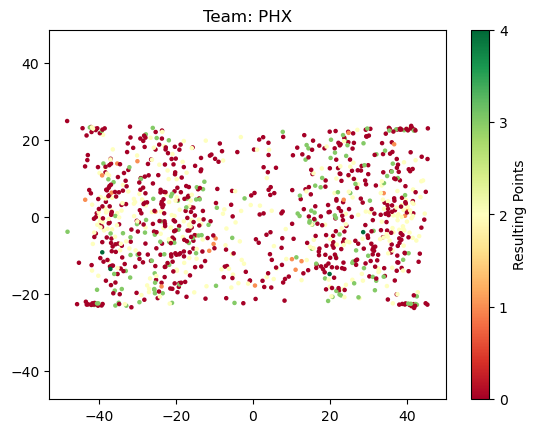

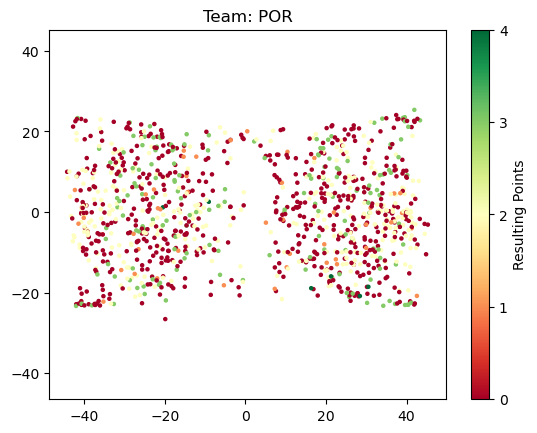

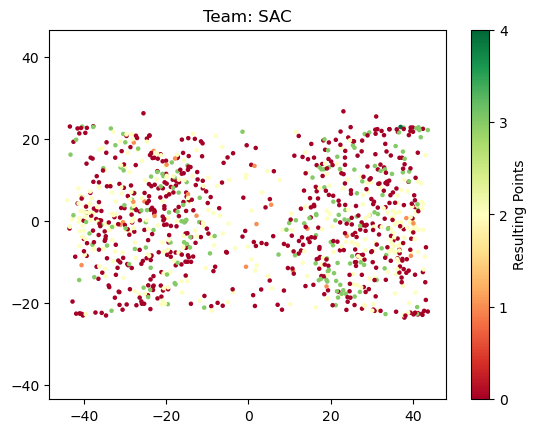

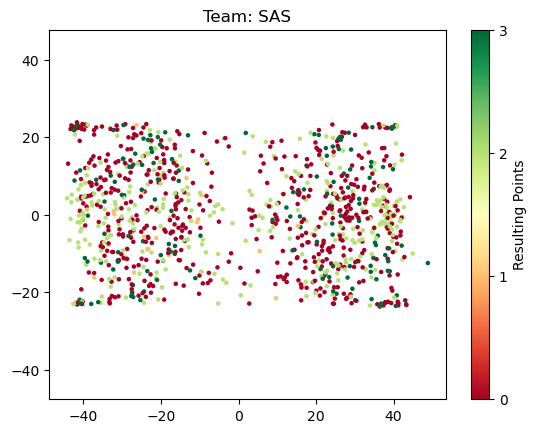

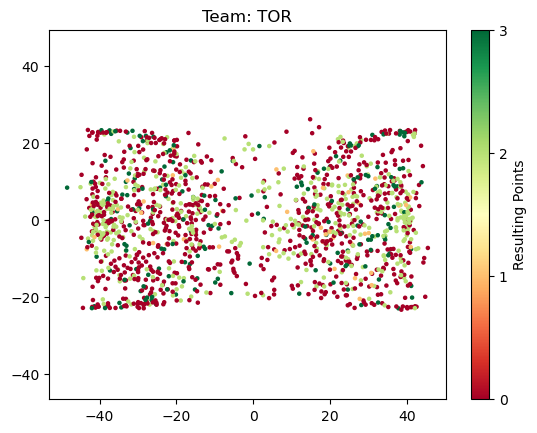

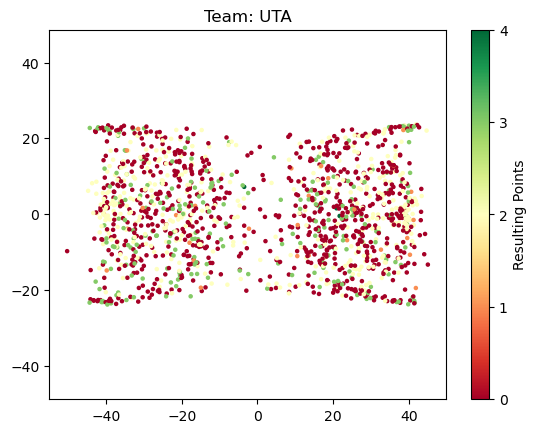

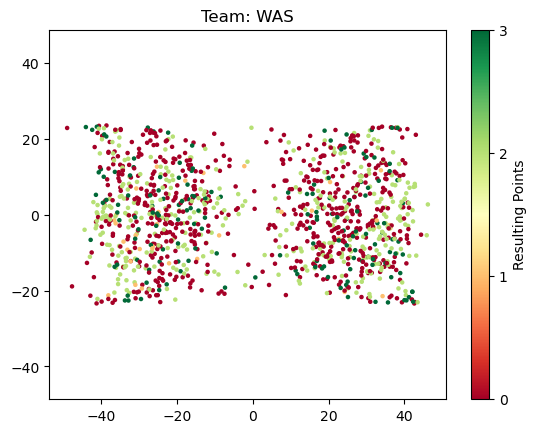

Empty DataFrame
Columns: []
Index: []

In [81]:
#graphing team shots overall, including missed shots
attempted_shots = data.dropna(subset = 'result_pts')
attempted_shots = attempted_shots[attempted_shots['result_type'] != 'TOV']
grouped_shots = attempted_shots.groupby('off_team')

cmap = plt.cm.get_cmap('RdYlGn')

def attempted_shots_graph(group):
    plt.axis('equal')
    sc = plt.scatter(group['player_x'], group['player_y'], c=group['result_pts'], cmap=cmap, marker='o', s=5)
    plt.colorbar(sc, label='Resulting Points', ticks=np.arange(0, max(group['result_pts']) + 1, 1))
    plt.title(f'Team: {group.name}')
    plt.show()

grouped_shots.apply(attempted_shots_graph)
#now we have made and missed shots by team, and where those shots took place

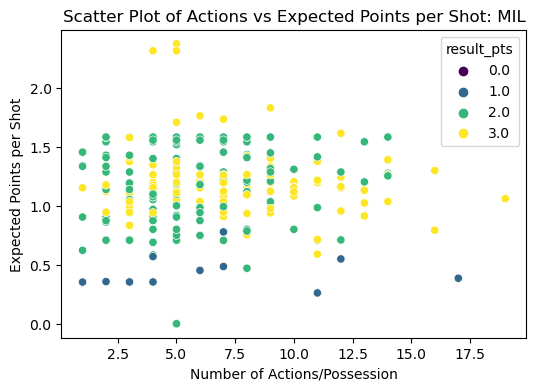

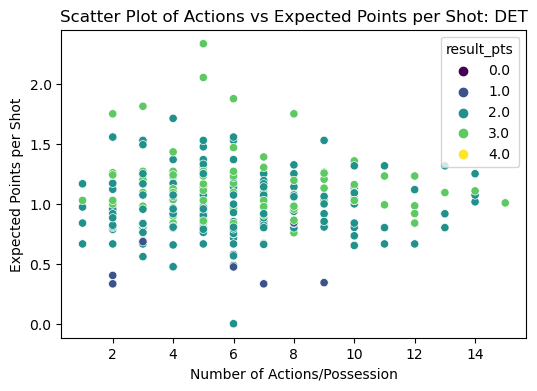

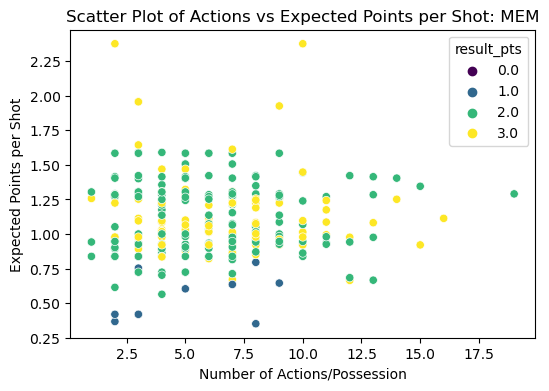

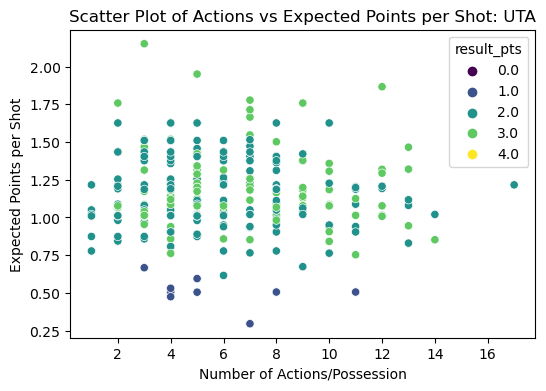

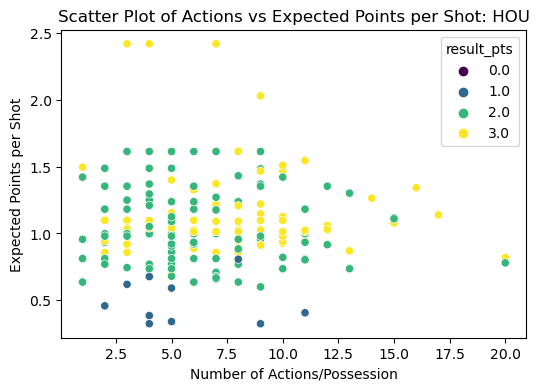

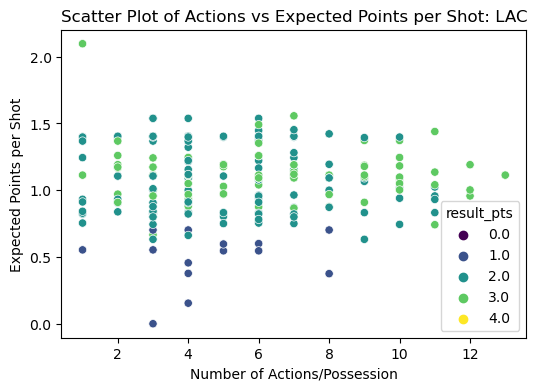

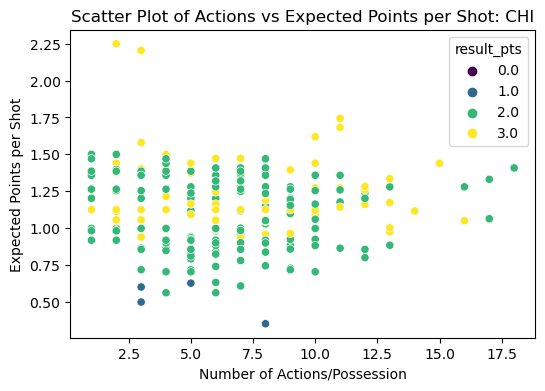

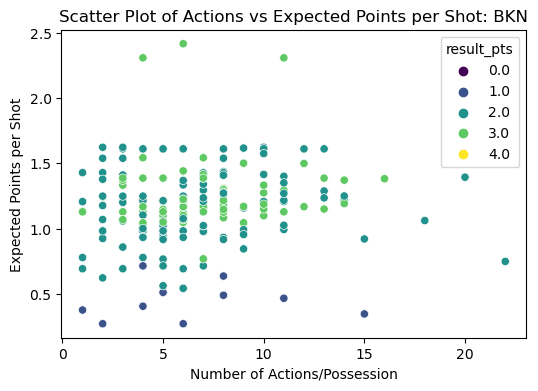

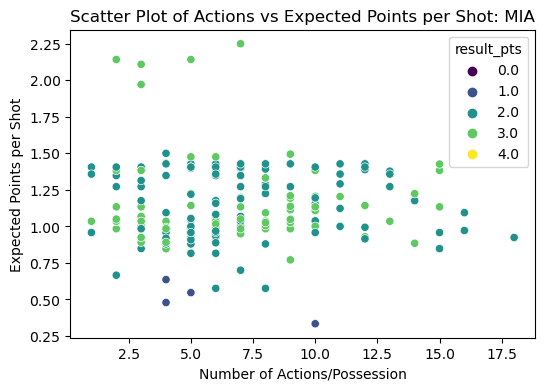

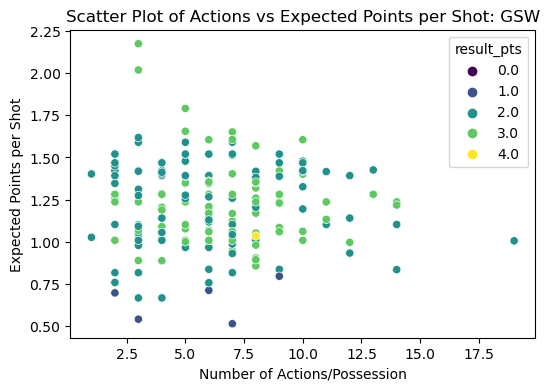

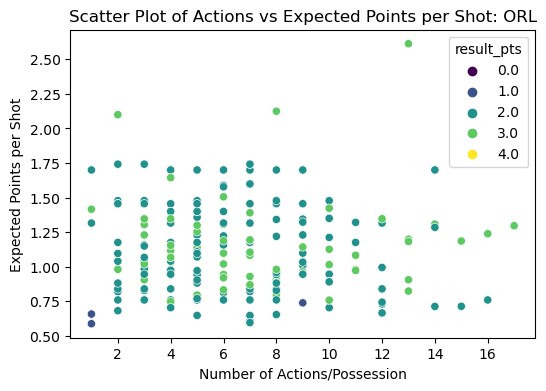

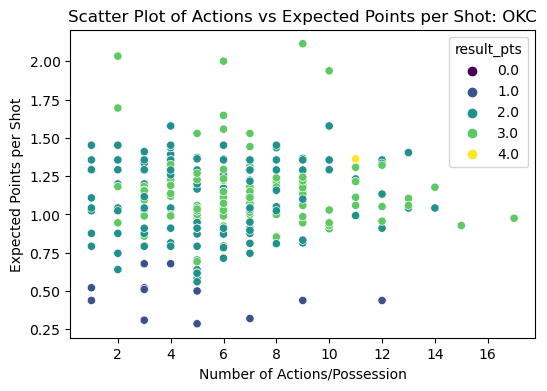

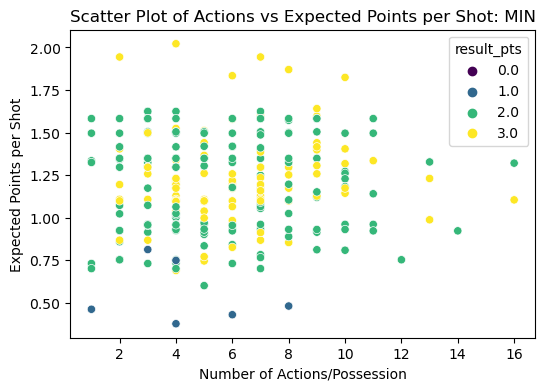

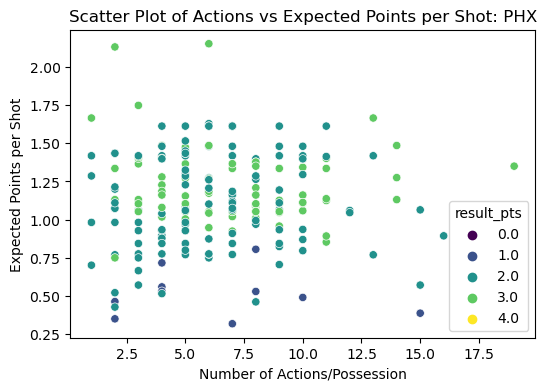

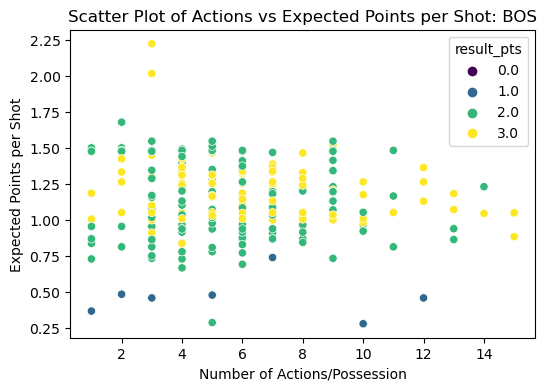

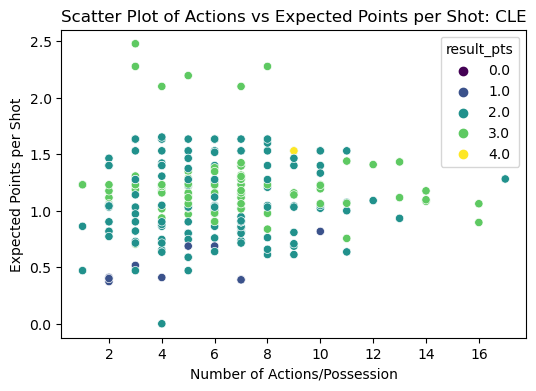

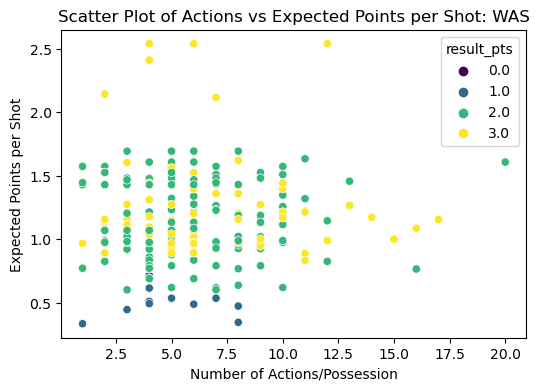

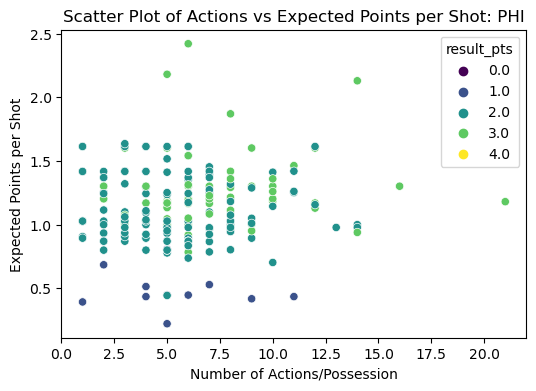

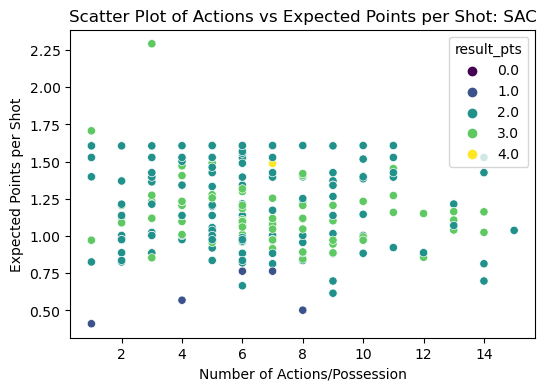

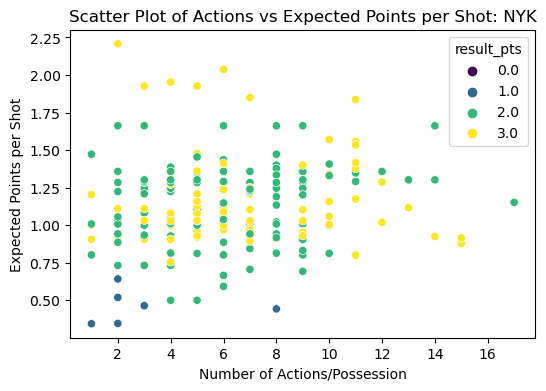

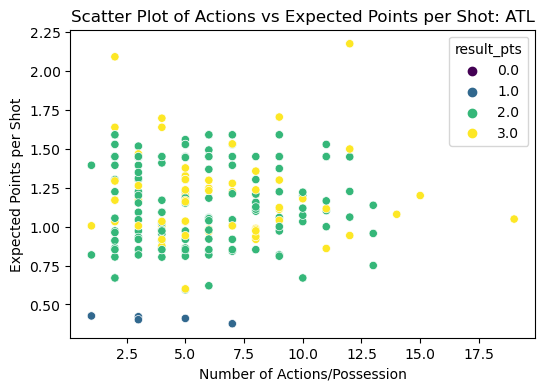

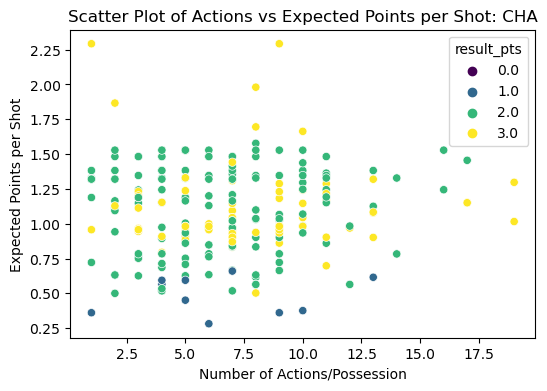

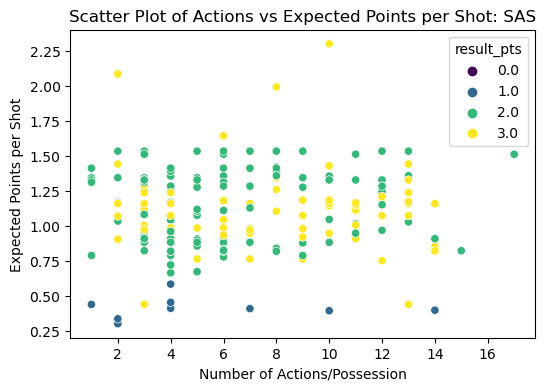

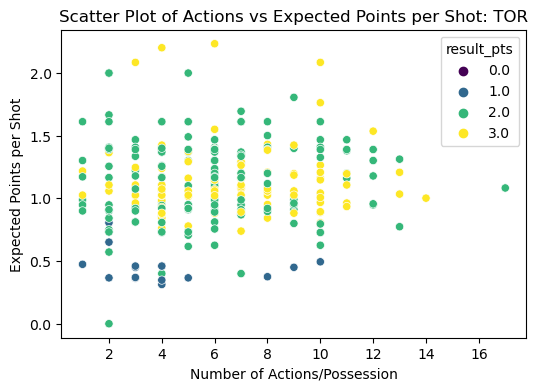

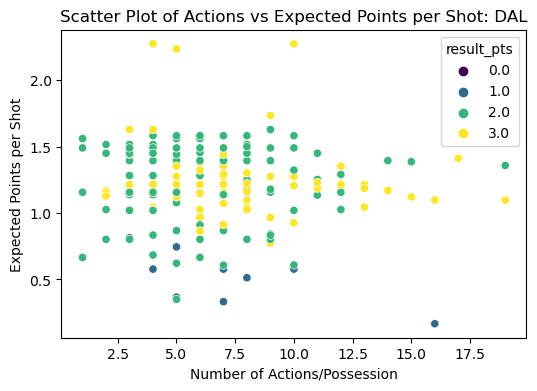

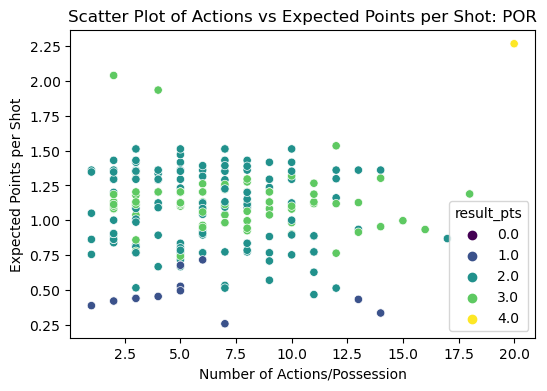

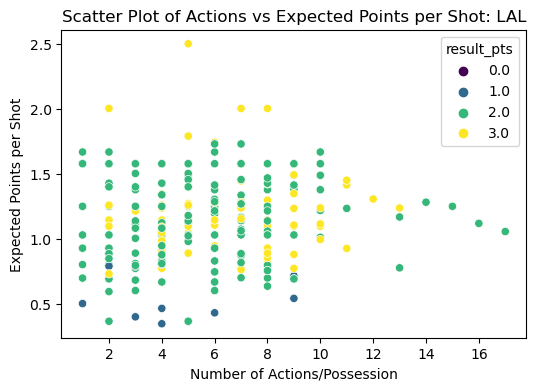

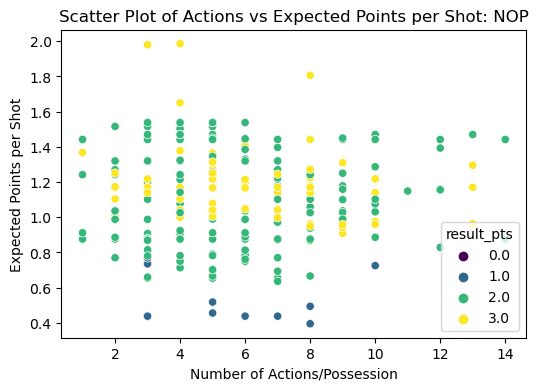

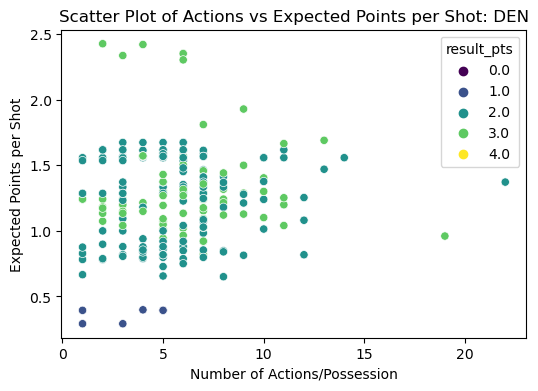

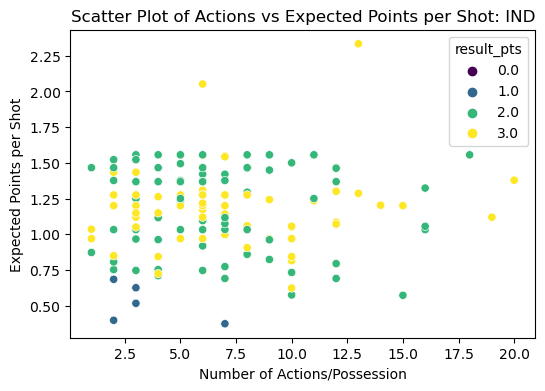

In [83]:
def fill_result_pts(group):
    if (group['result_pts'] >= 0).any():
        group['result_pts'] = group['result_pts'].max()
    return group

group_columns = ['off_team', 'nba_game_id', 'poss_id']

result_df = data.groupby(group_columns, group_keys=False).apply(fill_result_pts)
result_df = result_df.reset_index()

for off_team in result_df['off_team'].unique():
    off_team_data = result_df[result_df['off_team'] == off_team]
    scatter_data = off_team_data.groupby(['nba_game_id', 'poss_id']).apply(lambda x: pd.Series({
        'row_count': x.shape[0] / 2 if  (x.shape[0] % 2 == 0) else x.shape[0] / 2 + 0.5, 
        'Expected Points per Shot': x['Expected Points per Shot'].mean(),
        'result_pts': x['result_pts'].mean()
    })).reset_index()

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='row_count', y='Expected Points per Shot', hue='result_pts', data=scatter_data, palette='viridis')
    plt.title(f'Scatter Plot of Actions vs Expected Points per Shot: {off_team}')
    plt.xlabel('Number of Actions/Possession')
    plt.ylabel('Expected Points per Shot')
    plt.show()

In [132]:
import math

team_data = data.groupby(['off_team','nba_game_id', 'poss_id'])
action_threshold = 3

team_possessions = []
for (team, _, _,), team_possession in team_data:
    team_possession = team_possession[team_possession['off_def'] == 'OFF']
    action_list = []
    result_list = []
    for _, row in team_possession.iterrows():
        action_list.append(row['play_type'])
        result_list.append(row['result_pts'])
    result_list = [value for value in result_list if not math.isnan(value)]
    action_list = action_list[:action_threshold]
    #it gets too specific if you choose to ignore have more than three actions
    result = max(result_list) if result_list else 0
    team_possessions.append({'team': team, 'possessions': action_list, 'result': result})

#print(team_possessions)

In [137]:
def count_unique_entries(team_possessions):
    unique_entries = {}
    for entry in team_possessions:
        team = entry['team']
        possessions = tuple(entry['possessions'])
        results = entry['result']
        results = [results] if np.isscalar(results) else results
        result_mean = np.mean(results) if results else 0
        key = (team, possessions, result_mean)
        unique_entries[key] = {
            'results': results,
            'result_mean': result_mean,
            'count': unique_entries.get(key, {}).get('count', 0) + 1
        }
    return unique_entries

unique_counts = count_unique_entries(team_possessions)

#for key, entry in unique_counts.items():
#    team, possessions = key
#    result_mean, count = entry['result_mean'], entry['count']
#    print(f"Team: {team}, Possessions: {possessions}, Result Mean: {result_mean}, Count: {count}")

In [147]:
def separate_counts_by_team(unique_counts):
    team_data = {}
    for entry, count in unique_counts.items():
        team, possessions, result = entry
        if team not in team_data:
            team_data[team] = []
        team_data[team].append({'possessions': possessions, 'result': result, 'count': count})
    return team_data

team_separated_counts = separate_counts_by_team(unique_counts)

for team, entries in team_separated_counts.items():
    print(f"Team: {team}")
    for entry in entries:
        if entry['count']['count'] >= 3:
            print(f"  Possessions: {entry['possessions']}, Result: {entry['result']}, Count: {entry['count']}")

Team: ATL
  Possessions: ('Ball Screen', 'Ball Screen', 'Closeout'), Result: 0.0, Count: {'results': [0.0], 'result_mean': 0.0, 'count': 10}
  Possessions: ('Ball Screen', 'Ball Screen', 'Closeout'), Result: 2.0, Count: {'results': [2.0], 'result_mean': 2.0, 'count': 7}
  Possessions: ('Initiation', 'Off-Cut'), Result: 2.0, Count: {'results': [2.0], 'result_mean': 2.0, 'count': 4}
  Possessions: ('Ball Screen', 'Ball Screen', 'Ball Screen'), Result: 2.0, Count: {'results': [2.0], 'result_mean': 2.0, 'count': 18}
  Possessions: ('Ball Screen', 'Ball Screen', 'Off-Move'), Result: 0.0, Count: {'results': [0.0], 'result_mean': 0.0, 'count': 4}
  Possessions: ('Ball Screen', 'Ball Screen', 'Off-Move'), Result: 2.0, Count: {'results': [2.0], 'result_mean': 2.0, 'count': 6}
  Possessions: ('Ball Screen', 'Ball Screen', 'Ball Screen'), Result: 0.0, Count: {'results': [0.0], 'result_mean': 0.0, 'count': 10}
  Possessions: ('Initiation',), Result: 0.0, Count: {'results': [0.0], 'result_mean': 0.